In [236]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES/horizontal images/train hor 123.jpeg
/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES/horizontal images/train hor 114.jpeg
/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES/horizontal images/train hor 103.jpeg
/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES/horizontal images/train hor 1.jpeg
/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES/horizontal images/train hor 76.jpeg
/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES/horizontal images/train hor 67.jpeg
/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES/horizontal images/train hor 53.jpeg
/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES/horizontal images/train hor 48.jpeg
/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES/horizontal images/train hor 30.jpeg
/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES/horizontal images/train hor 79.jpeg
/kaggle/input/cnn-

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [238]:
pwd

'/kaggle/working'

In [239]:
dataset_path = '/kaggle/input/cnn-classifier'

In [240]:
extract_dataset_path = '/kaggle/input/cnn-classifier'

In [241]:
train_dataset_path = '/kaggle/input/cnn-classifier/cracks dataset/TRAIN DATA IMAGES'
validation_dataset_path = '/kaggle/input/cnn-classifier/cracks dataset/TEST DATA IMAGES'

In [242]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [243]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 585 images belonging to 4 classes.


In [244]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 214 images belonging to 4 classes.


In [245]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : diagonal images
1 : horizontal images
2 : structural images
3 : vertical images


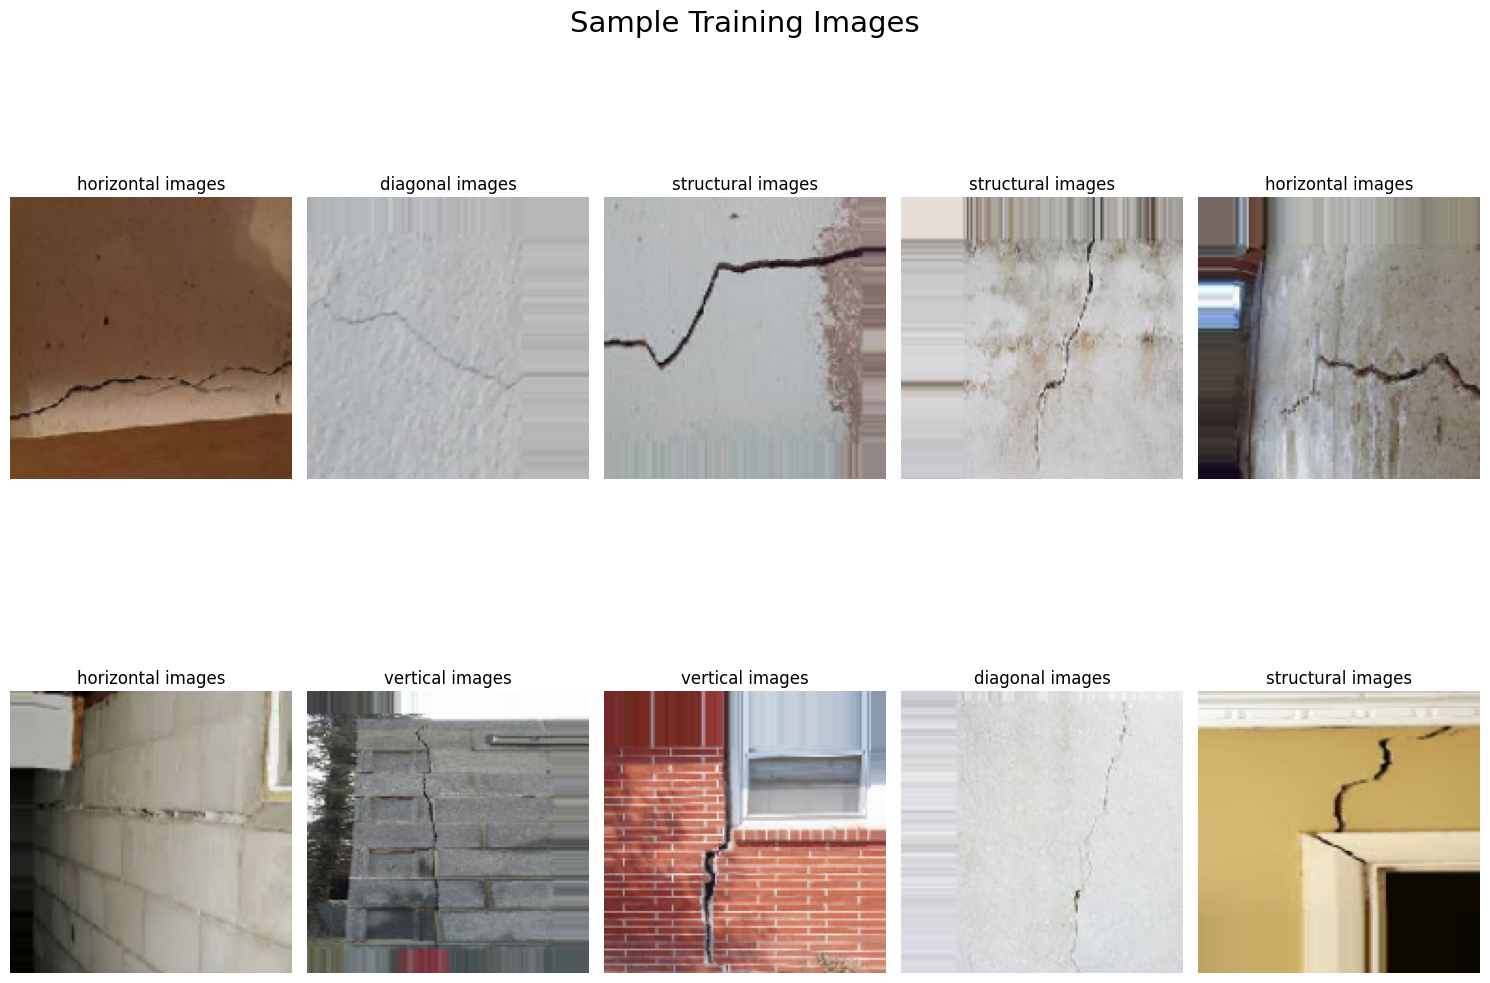

In [246]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [247]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])
    
    return model

In [248]:
cnn_model = create_model()

In [249]:
print(cnn_model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 146, 146, 128)     9728      
                                                                 
 activation_18 (Activation)  (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 73, 73, 128)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_18 (Ba  (None, 73, 73, 128)       512       
 tchNormalization)                                               
                                                                 
 conv2d_27 (Conv2D)          (None, 71, 71, 64)        73792     
                                                                 
 activation_19 (Activation)  (None, 71, 71, 64)      

In [250]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [251]:
optimizer = Adam(learning_rate=0.001)

In [252]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [253]:
from sklearn.preprocessing import LabelEncoder

# Example data
categories = ['diagonal images', 'horizontal images', 'structural images', 'vertical images']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
numerical_labels = label_encoder.fit_transform(categories)

# Print the mapping between categories and numerical labels
label_mapping = dict(zip(categories, numerical_labels))
print("Label Mapping:", label_mapping)


Label Mapping: {'diagonal images': 0, 'horizontal images': 1, 'structural images': 2, 'vertical images': 3}


In [254]:
categorical_labels = ['diagonal images', 'horizontal images', 'structural images', 'vertical images']


In [255]:
numerical_labels = [label_mapping[label] for label in categorical_labels]
print("Numerical Labels:", numerical_labels)


Numerical Labels: [0, 1, 2, 3]


In [256]:
from tensorflow.keras.utils import to_categorical

# Convert numerical labels to one-hot encoding
one_hot_labels = to_categorical(numerical_labels)
print("One-Hot Labels:\n", one_hot_labels)


One-Hot Labels:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [257]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Example data
categories = ['diagonal images', 'horizontal images', 'structural images', 'vertical images']

# Generate some dummy data for illustration purposes
num_samples = 585
image_shape = (28, 28, 1)
x_data = np.random.rand(num_samples, *image_shape)  
y_categorical = np.random.choice(categories, num_samples)  

# Convert categorical labels to numerical labels
label_encoder = LabelEncoder()
y_numerical = label_encoder.fit_transform(y_categorical)

# Convert numerical labels to one-hot encoding
y_one_hot = to_categorical(y_numerical)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_one_hot, test_size=0.2, random_state=42)

# Build a simple CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))  # Output layer with the number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10  # Adjust the number of epochs as needed
model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



Epoch 1/10
15/15 [==============================] - 1s 34ms/step - loss: 1.4362 - accuracy: 0.2329 - val_loss: 1.4099 - val_accuracy: 0.2906
Epoch 2/10
15/15 [==============================] - 0s 19ms/step - loss: 1.3930 - accuracy: 0.2863 - val_loss: 1.3793 - val_accuracy: 0.2906
Epoch 3/10
15/15 [==============================] - 0s 18ms/step - loss: 1.3759 - accuracy: 0.3248 - val_loss: 1.3827 - val_accuracy: 0.2137
Epoch 4/10
15/15 [==============================] - 0s 18ms/step - loss: 1.3609 - accuracy: 0.3355 - val_loss: 1.3814 - val_accuracy: 0.2222
Epoch 5/10
15/15 [==============================] - 0s 18ms/step - loss: 1.3398 - accuracy: 0.4487 - val_loss: 1.3851 - val_accuracy: 0.2137
Epoch 6/10
15/15 [==============================] - 0s 17ms/step - loss: 1.3148 - accuracy: 0.5534 - val_loss: 1.3817 - val_accuracy: 0.2650
Epoch 7/10
15/15 [==============================] - 0s 16ms/step - loss: 1.2875 - accuracy: 0.4808 - val_loss: 1.3924 - val_accuracy: 0.2222
Epoch 8/10
15

In [258]:
# Assuming you have trained your model like this
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

# Accessing training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Now you can use these variables for analysis or plotting


Epoch 1/10
15/15 [==============================] - 0s 21ms/step - loss: 1.1107 - accuracy: 0.6432 - val_loss: 1.4008 - val_accuracy: 0.2393
Epoch 2/10
15/15 [==============================] - 0s 17ms/step - loss: 1.0464 - accuracy: 0.7799 - val_loss: 1.4265 - val_accuracy: 0.2564
Epoch 3/10
15/15 [==============================] - 0s 18ms/step - loss: 0.9720 - accuracy: 0.7927 - val_loss: 1.4029 - val_accuracy: 0.2479
Epoch 4/10
15/15 [==============================] - 0s 17ms/step - loss: 0.8998 - accuracy: 0.7393 - val_loss: 1.4363 - val_accuracy: 0.2650
Epoch 5/10
15/15 [==============================] - 0s 17ms/step - loss: 0.8265 - accuracy: 0.7756 - val_loss: 1.4939 - val_accuracy: 0.2821
Epoch 6/10
15/15 [==============================] - 0s 17ms/step - loss: 0.7465 - accuracy: 0.8996 - val_loss: 1.5041 - val_accuracy: 0.2564
Epoch 7/10
15/15 [==============================] - 0s 17ms/step - loss: 0.6841 - accuracy: 0.9103 - val_loss: 1.5645 - val_accuracy: 0.2735
Epoch 8/10
15

In [259]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule
def lr_schedule(epoch):
    """
    Returns a learning rate based on the epoch number.
    You can customize this function according to your needs.
    """
    initial_lr = 0.001
    decay_factor = 0.9
    decay_step = 5
    lr = initial_lr * (decay_factor ** (epoch // decay_step))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with the callback
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), callbacks=[lr_scheduler])

# Accessing training history including learning rate
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
learning_rate = [lr_schedule(epoch) for epoch in range(epochs)]


Epoch 1/10
15/15 [==============================] - 0s 23ms/step - loss: 0.3984 - accuracy: 0.9765 - val_loss: 1.6150 - val_accuracy: 0.2650 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 0s 19ms/step - loss: 0.3284 - accuracy: 1.0000 - val_loss: 1.7344 - val_accuracy: 0.2393 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 0s 19ms/step - loss: 0.2952 - accuracy: 0.9893 - val_loss: 1.7319 - val_accuracy: 0.2479 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 0s 19ms/step - loss: 0.2723 - accuracy: 0.9915 - val_loss: 1.7824 - val_accuracy: 0.2821 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - 0s 21ms/step - loss: 0.2129 - accuracy: 1.0000 - val_loss: 1.7248 - val_accuracy: 0.2821 - lr: 0.0010
Epoch 6/10
15/15 [==============================] - 0s 18ms/step - loss: 0.1782 - accuracy: 1.0000 - val_loss: 1.7955 - val_accuracy: 0.2906 - lr: 9.0000e-04
Epoch 7/10
15/15 [==============================] - 0s 22ms/step - loss:

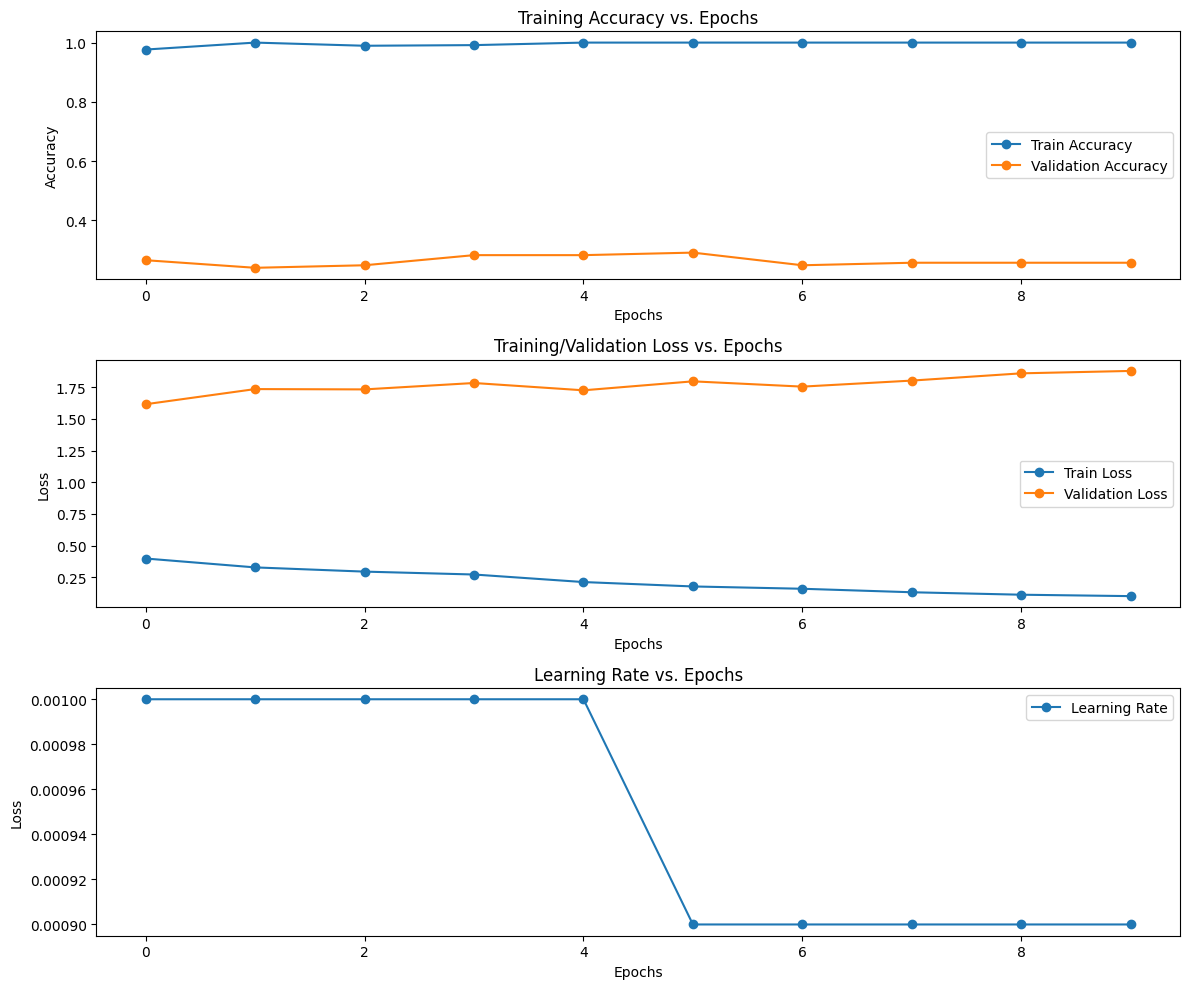

In [260]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [261]:
test_dataset = '/kaggle/input/cnn-classifier/cracks dataset/TEST DATA IMAGES'

In [262]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 214 images belonging to 4 classes.


In [263]:
predictions = cnn_model.predict(test_generator)

7/7 [==============================] - 11s 1s/step


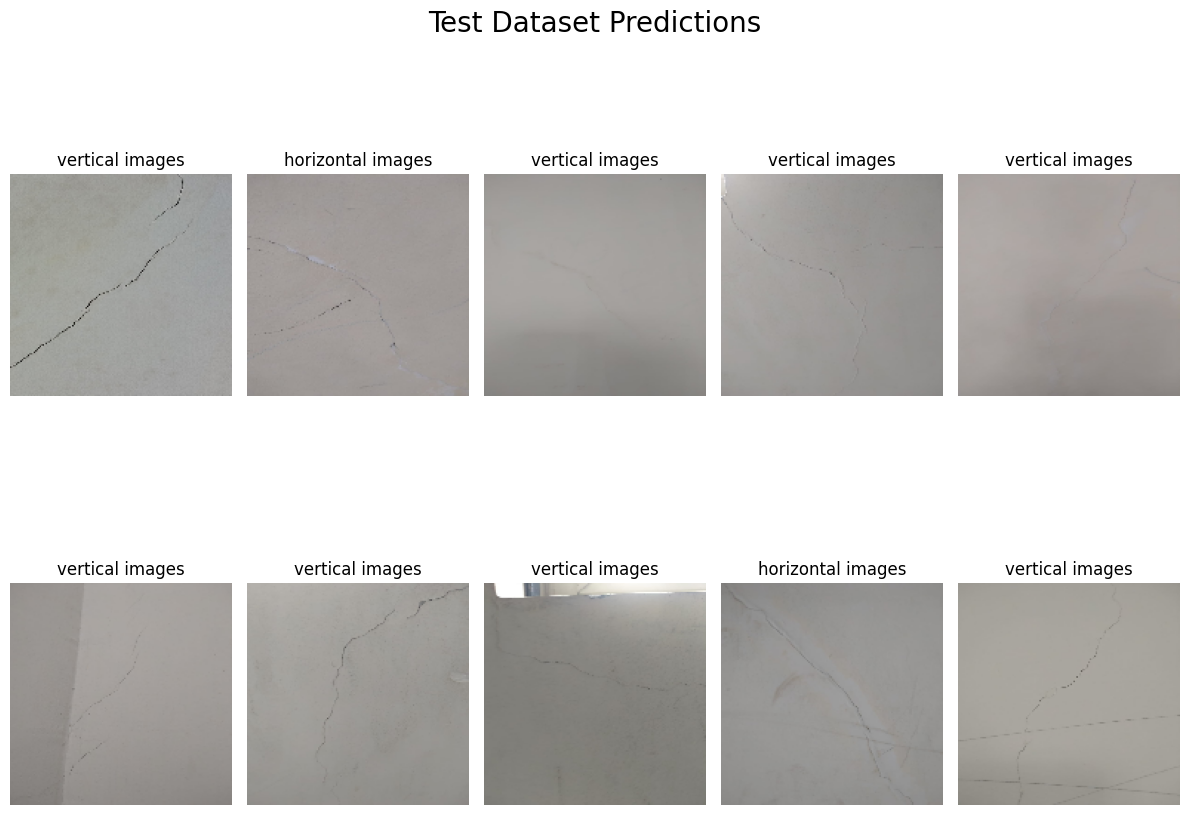

In [264]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        if idx < len(predictions):
            predicted_label = labels[np.argmax(predictions[idx])]
            ax[i, j].set_title(f"{predicted_label}")
            ax[i, j].imshow(test_generator[0][0][idx])
            ax[i, j].axis("off")
            idx += 1
        else:
            print("Index out of bounds. Exiting the loop.")
            break

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()






In [265]:
batch_size = 32

In [268]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

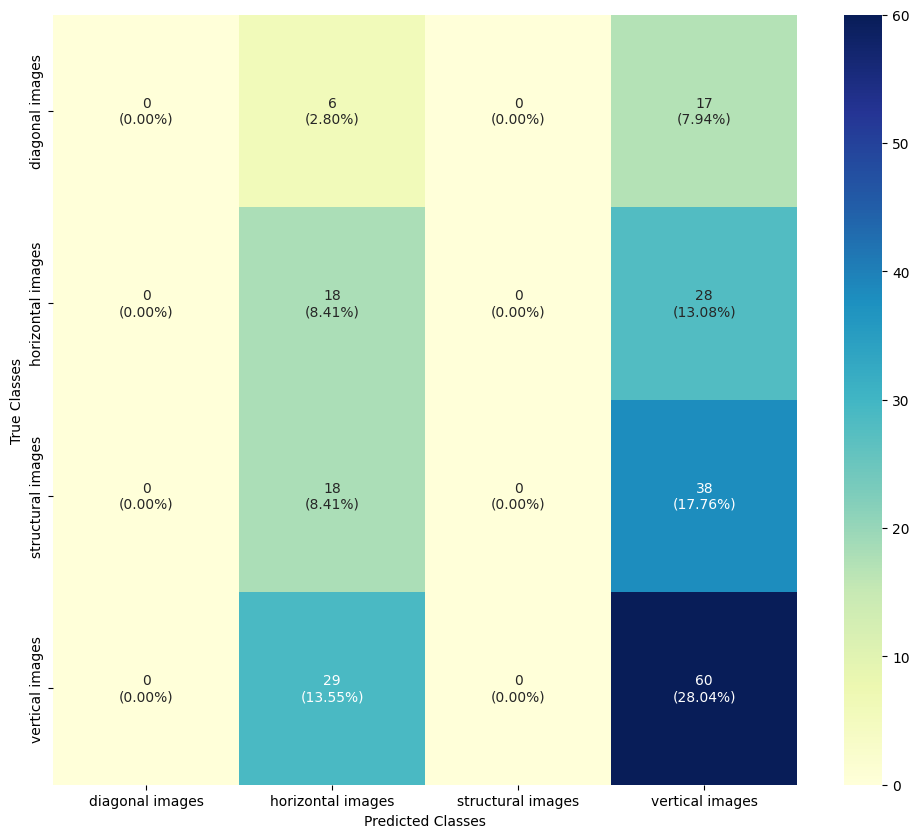

In [270]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(4, 4)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [271]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                   precision    recall  f1-score   support

  diagonal images       0.00      0.00      0.00        23
horizontal images       0.25      0.39      0.31        46
structural images       0.00      0.00      0.00        56
  vertical images       0.42      0.67      0.52        89

         accuracy                           0.36       214
        macro avg       0.17      0.27      0.21       214
     weighted avg       0.23      0.36      0.28       214



In [272]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [273]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

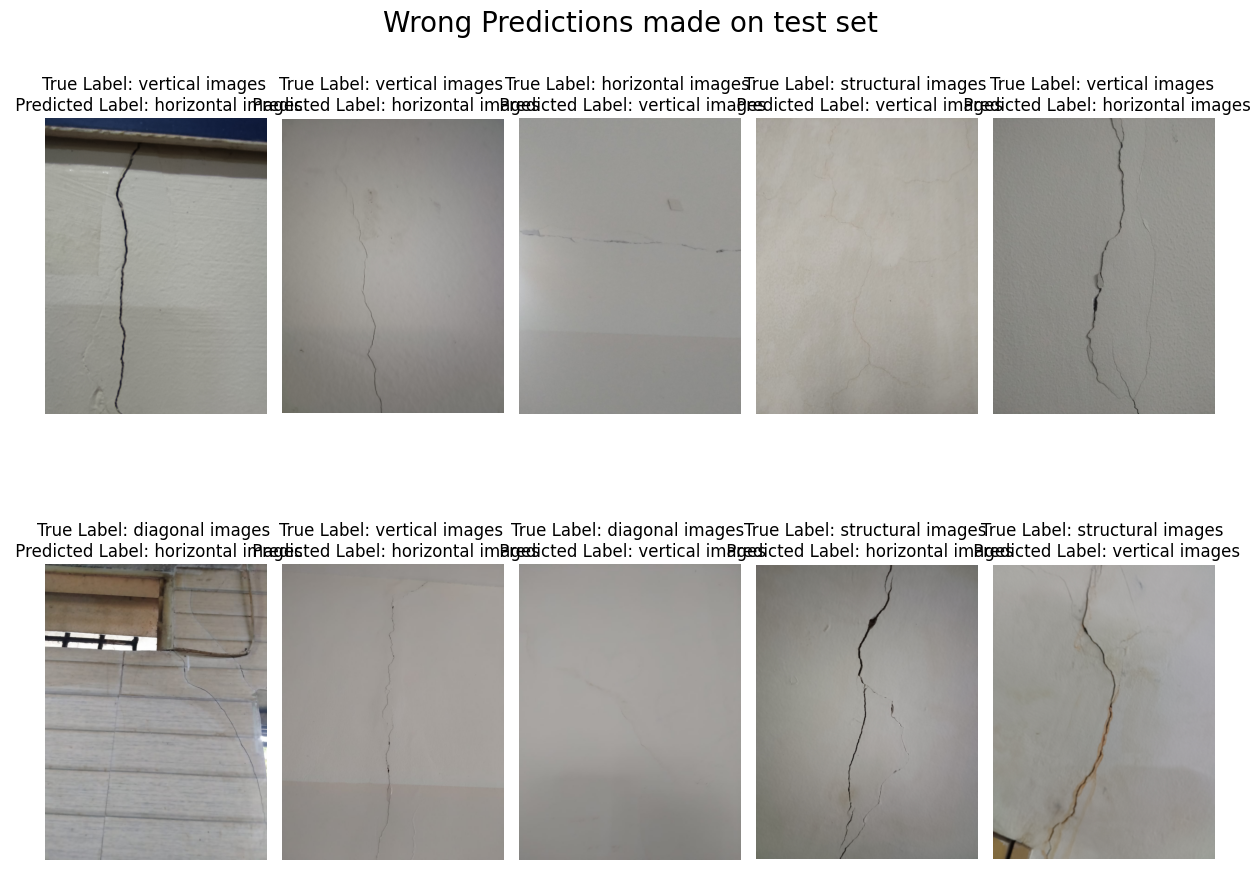

In [275]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()